In [24]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import numpy as np; np.random.seed(42)
import glob, os, cv2, json
from PIL import Image
from tqdm import tqdm
%matplotlib notebook

In [25]:
grasp_names = ["Large Diameter", "Small Diameter", "Medium Wrap", "Adducted Thumb", "Light Tool",
    "Prismatic 4 Finger", "Prismatic 3 Finger", "Prismatic 2 Finger", "Palmar Pinch",
    "Power Disk", "Power Sphere", "Precision Disk", "Precision Sphere", "Tripod", "Fixed Hook",
    "Lateral", "Index Finger Extension", "Extension Type", "Distal", "Writing Tripod", "Tripod Variation",
    "Parallel Extension", "Adduction Grip", "Tip Pinch", "Lateral Tripod", "Sphere 4-Finger", "Quadpod",
    "Sphere 3-Finger", "Stick", "Palmar", "Ring", "Ventral", "Inferior Pincer"]

In [26]:
model_name = f'SegNet_hands_nosupckpt27_seed0_ROI350_YCB75'
im_dir = f"/home/mohit/VOS/epic-affordances/evaluation/epic-roi/data/roi-data/images_val"
pred_dir = f"/home/mohit/VOS/epic-affordances/training/inferred_IHdata/epicaff_benchmark/{model_name}"
roi_dir = f"/home/mohit/VOS/epic-affordances/training/src/visualisations/inferred_vis/epic/SegNet_hands_nosupckpt27_seed0_350"
annot_path = f"/home/mohit/VOS/epic-affordances/evaluation/epic-roi/data/annotated_frames.json"
metadata = json.load(open(annot_path, 'r'))

im_list = [f"{im_dir}/{i[:-4]}.jpg" for i in metadata['val_images']]

In [27]:
scales = {i: {'min': float("inf"), 'max': -float("inf")} for i in range(len(grasp_names))}

for image_ind in tqdm(range(len(im_list))):
    im_name = im_list[image_ind]
    hm_name = pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy"
    hm = np.load(hm_name)
    
    for j in range(33):    
        sigmaX = 3
        hm[:,:,j] = cv2.GaussianBlur(hm[:,:,j]+0, (int(sigmaX*6+1), int(sigmaX*6+1)), sigmaX=sigmaX)

    for hm_id in range(hm.shape[2]):
        scales[hm_id]['min'] = min(scales[hm_id]['min'], np.min(hm[:, :, hm_id]))
        scales[hm_id]['max'] = max(scales[hm_id]['max'], np.max(hm[:, :, hm_id]))

100%|██████████| 32/32 [01:00<00:00,  1.90s/it]


In [28]:
global IIII, img, hm
IIII = 9
im_name = im_list[IIII]
hm_name = pred_dir + "/final_" + os.path.basename(im_name)[:-3] + "npy"
fname = os.path.splitext(os.path.basename(im_name))[0]
roi_name = roi_dir + "/" + os.path.basename(im_name)[:-4] + '_hmsmall.png'

img = Image.open(im_name)
hm = np.load(hm_name)
roi = Image.open(roi_name)

for j in range(33):    
    sigmaX = 3
    hm[:,:,j] = cv2.GaussianBlur(hm[:,:,j]+0, (int(sigmaX*6+1), int(sigmaX*6+1)), sigmaX=sigmaX)
    # Uncomment to scale the grasp predictions
    hm[:,:,j] = (hm[:,:,j] - scales[j]['min'])/(scales[j]['max'] - scales[j]['min'])

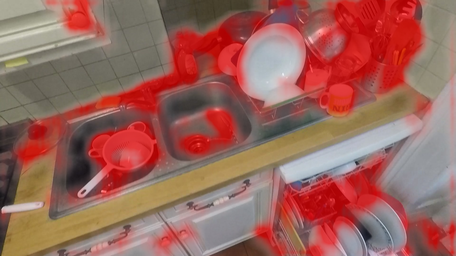

In [29]:
roi

<IPython.core.display.Javascript object>


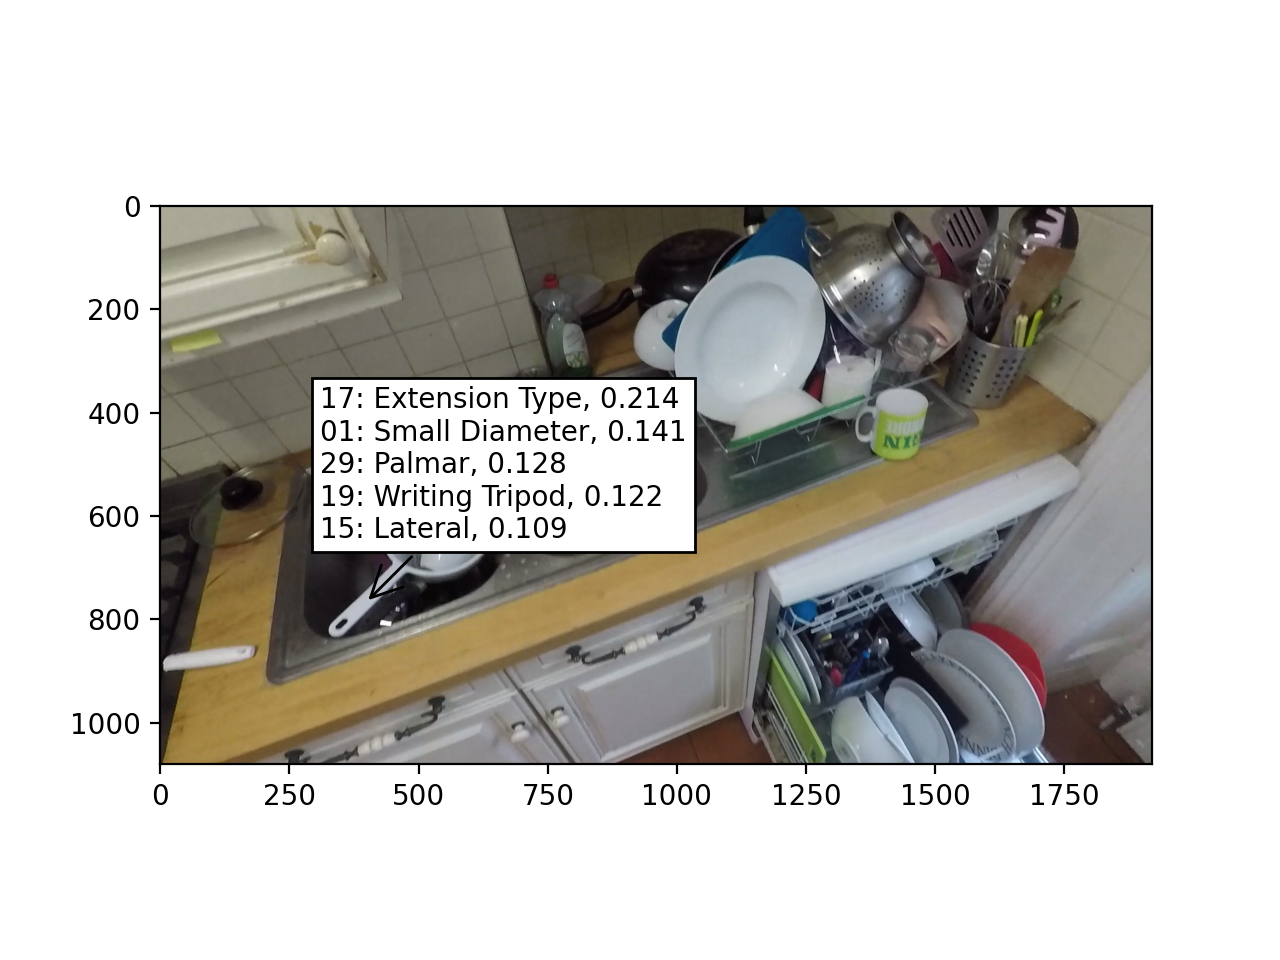

In [30]:
# create figure and plot scatter
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img)

# create the annotations box
im = TextArea('Grasp')
xybox=(50., 50.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
                    boxcoords="offset points",  pad=0.3,  
                    arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(True)

def on_click(event):
    # if the mouse is over the scatter points

    
    w,h = fig.get_size_inches()*fig.dpi
    ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
    hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
    # if event occurs in the top or right quadrant of the figure,
    # change the annotation box position relative to mouse.
    ab.xybox = (xybox[0]*ws, xybox[1]*hs)
    # make annotation box visible
    ab.set_visible(True)
    # place it at the position of the hovered scatter point
    ab.xy = (event.xdata, event.ydata)# x[ind], y[ind])
    # set the image corresponding to that point
    xdata = int(event.xdata)
    ydata = int(event.ydata)
    
    all_scores = hm[ydata, xdata, :]
    ind = np.argsort(all_scores)[::-1]
    texts = []
    for j in range(5):
        texts.append(f'{ind[j]:02d}: {grasp_names[ind[j]]}, {all_scores[ind[j]]:0.3f}')
    texts = '\n'.join(texts)
    im.set_text(texts)
    
    fig.canvas.draw_idle()
              
fig.canvas.mpl_connect('button_press_event', on_click)           
plt.show()